## 1. 라이브러리 로드

In [1]:
#라이브러리 설치
import math
import sys
!{sys.executable} -m pip install --upgrade https://github.com/aparrish/bezmerizing/archive/master.zip
    
from flat import document, rgb, rgba, font, strike, shape
from flat.command import moveto, quadto, curveto, lineto, closepath
from bezmerizing import Polyline, Path
import numpy as np
from copy import copy

from numpy.random import uniform, normal, choice, uniform

from IPython.display import SVG, display  # Scalable Vector Graphics, SVG
def show(page):
    display(SVG(page.svg()))

  Using cached https://github.com/aparrish/bezmerizing/archive/master.zip


## 2. 폰트 로드

In [2]:
f = font.open("fonts/NanumSquare_0.ttf")

print("폰트명:", f.name)
print("Density:", f.density)

폰트명: b'NanumSquare_acEB'
Density: 1000


## 3. 자주 사용할 함수 정의

In [3]:
def glyphcommands(f, ch):
    return Path([copy(cmd) for cmd in f.glyph(f.charmap[ord(ch)])])

def advancefor(f, ch):
    return f.advances[f.charmap[ord(ch)]]

## 4. 글리프 불러오기

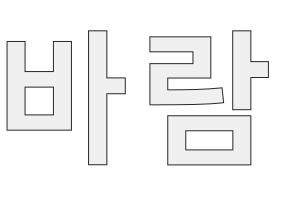

In [4]:
gu_path_orig = glyphcommands(f, "바")
reum_path_orig = glyphcommands(f, "람")

page = document(300, 200, 'pt').addpage()
pen = shape().stroke(rgb(40, 40, 40)).fill(rgb(240, 240, 240))
page.place(pen.path(gu_path_orig.scale(144/f.density).translate(0, 144)))
page.place(pen.path(reum_path_orig.scale(144/f.density).translate(144, 144)))
show(page)

In [5]:
for i in gu_path_orig.commands:
    if hasattr(i, 'x') and hasattr(i, 'y'):
        print(type(i), ":", i.x, i.y)
    else:
        print(type(i))

<class 'flat.command.moveto'> : 742 -786
<class 'flat.command.lineto'> : 742 -459
<class 'flat.command.lineto'> : 870 -459
<class 'flat.command.lineto'> : 870 -349
<class 'flat.command.lineto'> : 742 -349
<class 'flat.command.lineto'> : 742 144
<class 'flat.command.lineto'> : 615 144
<class 'flat.command.lineto'> : 615 -786
<class 'flat.command.lineto'> : 742 -786
<class 'flat.command.closepath'>
<class 'flat.command.moveto'> : 496 -712
<class 'flat.command.lineto'> : 496 -96
<class 'flat.command.lineto'> : 49 -96
<class 'flat.command.lineto'> : 49 -712
<class 'flat.command.lineto'> : 174 -712
<class 'flat.command.lineto'> : 174 -503
<class 'flat.command.lineto'> : 371 -503
<class 'flat.command.lineto'> : 371 -712
<class 'flat.command.lineto'> : 496 -712
<class 'flat.command.closepath'>
<class 'flat.command.moveto'> : 174 -395
<class 'flat.command.lineto'> : 174 -202
<class 'flat.command.lineto'> : 371 -202
<class 'flat.command.lineto'> : 371 -395
<class 'flat.command.lineto'> : 174 -3

In [6]:
for i in reum_path_orig.commands:
    if hasattr(i, 'x') and hasattr(i, 'y'):
        print(type(i), ":", i.x, i.y)
    else:
        print(type(i))

<class 'flat.command.moveto'> : 165 145
<class 'flat.command.lineto'> : 165 -196
<class 'flat.command.lineto'> : 742 -196
<class 'flat.command.lineto'> : 742 145
<class 'flat.command.lineto'> : 165 145
<class 'flat.command.closepath'>
<class 'flat.command.moveto'> : 290 -92
<class 'flat.command.lineto'> : 290 41
<class 'flat.command.lineto'> : 617 41
<class 'flat.command.lineto'> : 617 -92
<class 'flat.command.lineto'> : 290 -92
<class 'flat.command.closepath'>
<class 'flat.command.moveto'> : 742 -786
<class 'flat.command.lineto'> : 742 -572
<class 'flat.command.lineto'> : 864 -572
<class 'flat.command.lineto'> : 864 -462
<class 'flat.command.lineto'> : 742 -462
<class 'flat.command.lineto'> : 742 -238
<class 'flat.command.lineto'> : 616 -238
<class 'flat.command.lineto'> : 616 -786
<class 'flat.command.lineto'> : 742 -786
<class 'flat.command.closepath'>
<class 'flat.command.moveto'> : 165 -458
<class 'flat.command.lineto'> : 165 -376
<class 'flat.command.quadto'> : 360.0 -378.5
<clas

## 5. 폰트 글리프 변형

### 5-1. 각 글리프들의 방향 알아내기

In [7]:
def get_dir_of_glyph(cmd, pre_x, pre_y):

    direct = ""    
    if type(cmd) == moveto:
        direct += "start"
        return direct
    
    if cmd.x > pre_x:
        direct += "+right"
    elif cmd.x < pre_x:
        direct += "+left"
    else:
        direct += ""
    
    if cmd.y > pre_y:
        direct += "+down"
    elif cmd.y < pre_y:
        direct += "+up"
    else:
        direct += ""
        
   
    return direct

In [8]:
def get_dir_list(path):
    dir_list = []
    
    pre_x, pre_y = -9999, -9999
    for idx, cmd in enumerate(path):
        if type(cmd) == moveto:
            pre_x = cmd.x
            pre_y = cmd.y
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
        elif type(cmd) in (lineto, quadto, curveto):
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
            pre_x = cmd.x
            pre_y = cmd.y
        else:
            dir_list.append("fin")
    
    return dir_list

### 5-2. 각 글리프를 2차 베지어 곡선으로 변경 및 디자인 적용
* 구름 디자인 적용: mod_cloud_corrdinate_value()

In [9]:
# 아웃라인을 따라 바람이 부는 것처럼 뾰족뾰족해지는 디자인
def mod_wind_corrdinate_value(direct, pre_x, pre_y, av, cmd, wave_flag):
    
    if wave_flag == 0:
        av = av
    else:
        av = av * -1
    
    if direct.count('+')==2:  # 대각선
        c = copy(cmd)
    else:  # 상하좌우
        av = av * uniform(0.5, 1.5)
        
        if "up" in direct:
            c = lineto(x=pre_x - av, y=cmd.y) #바람
            wave_flag = 0 if wave_flag == 1 else 1
        else:
            c = copy(cmd)
    
    return c, wave_flag

In [10]:
# cmd: glyph
# direct: direction of glyph
# av: Adjustment value - how much we will change the glyph
def change_glyph(cmd, direct, av, pre_x, pre_y, wave_flag):
    
    if type(cmd) == moveto:
        c = moveto(cmd.x, cmd.y)
    elif type(cmd) in (lineto, quadto, curveto):
        mid_x = (cmd.x + pre_x) / 2
        mid_y = (cmd.y + pre_y) / 2
        # print(direct,":", pre_x, mid_x, cmd.x)
        # print(direct,":", pre_y, mid_y, cmd.y)

        #디자인 적용
        c, wave_flag = mod_wind_corrdinate_value(direct, pre_x, pre_y, av, cmd, wave_flag)  # 물방울 디자인
    else:
        c = closepath

    return c, wave_flag

In [11]:
def make_design_glyph(input_path, glyph_dir, av):
    pre_x = 0
    pre_y = 0

    design_glyph_list = []
    wave_flag = 0
    for idx, cmd in enumerate(input_path):
        if type(cmd) == moveto:
            pre_x = cmd.x
            pre_y = cmd.y
            c, wave_flag = change_glyph(cmd, glyph_dir[idx], av, pre_x, pre_y, wave_flag)
        elif type(cmd) in (lineto, quadto, curveto):
            c, wave_flag = change_glyph(cmd, glyph_dir[idx], av, pre_x, pre_y, wave_flag)
            pre_x = cmd.x
            pre_y = cmd.y
        else:
            c = closepath
            pre_x = 0
            pre_y = 0

        design_glyph_list.append(c)
        
    return design_glyph_list

In [22]:
def cut_glyph(cut_dir, cut_num, origin_glyph, origin_glyph_dir):
    
    cutted_glyph = []
    pre_x, pre_y = -9999, -9999

    for idx, cmd in enumerate(origin_glyph):
        
        if type(cmd) == moveto:  # moveto (시작일경우)
            pre_x, pre_y = cmd.x, cmd.y
            c = moveto(cmd.x, cmd.y)
            cutted_glyph.append(c)
            
        elif type(cmd) == lineto and origin_glyph_dir[idx] in cut_dir:  # cut (자르고자 하는 방향의 글리프인 경우)
            
            #길이 계산
            glyph_length = math.sqrt((cmd.x - pre_x)**2 + (cmd.y - pre_y)**2)
            
            if glyph_length <= 50: # 일정 길이 이하일 때는 그냥 있던 디자인 그대로
                c = lineto(cmd.x, cmd.y)
                cutted_glyph.append(c)
                pre_x, pre_y = cmd.x, cmd.y    
                continue
            else: # 길이에 따라서 자르는 개수를 다르게 함
                cut_num = int(glyph_length / 30) * 2 + 1
    
            if origin_glyph_dir[idx] == "+right":
                for i in  range(1, cut_num + 1):
                    temp_x = pre_x + i * (cmd.x - pre_x) / cut_num
                    c = lineto(temp_x, cmd.y)
                    cutted_glyph.append(c)
            elif origin_glyph_dir[idx] == "+down":
                for i in  range(1, cut_num + 1):
                    temp_y = pre_y + i * (cmd.y - pre_y) / cut_num
                    c = lineto(cmd.x, temp_y)
                    cutted_glyph.append(c)
            elif origin_glyph_dir[idx] == "+left":
                for i in  range(1, cut_num + 1):
                    temp_x = pre_x - i * (pre_x - cmd.x) / cut_num
                    c = lineto(temp_x, cmd.y)
                    cutted_glyph.append(c)
            elif origin_glyph_dir[idx] == "+up":
                for i in  range(1, cut_num + 1):
                    temp_y = pre_y - i * (pre_y - cmd.y) / cut_num
                    c = lineto(cmd.x, temp_y)
                    cutted_glyph.append(c)
                    
            pre_x, pre_y = cmd.x, cmd.y
                
        elif type(cmd) in (lineto, quadto, curveto):  # etc (그 외의 건드리지 않을 글리프인 경우)
            
            glyph_length = math.sqrt((cmd.x - pre_x)**2 + (cmd.y - pre_y)**2)
            # print(origin_glyph_dir[idx], ":", glyph_length)
            
            if type(cmd) == lineto:
                c = lineto(cmd.x, cmd.y)
            elif type(cmd) == quadto:
                c = quadto(x1=cmd.x1, y1=cmd.y1, x=cmd.x, y=cmd.y)
            elif type(cmd) == curveto:
                c = curveto(x1=cmd.x1, y1=cmd.y1, x2=cmd.x2, y2=cmd.y2, x=cmd.x, y=cmd.y)
            pre_x = cmd.x
            pre_y = cmd.y
            cutted_glyph.append(c)
            
        else:  # closepath (글리프를 끝낼 경우)
            c = closepath
            cutted_glyph.append(c)
    
    return cutted_glyph

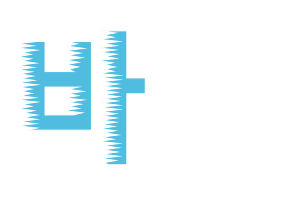

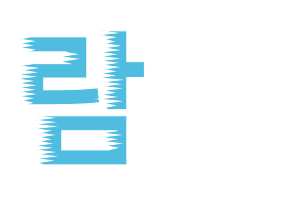

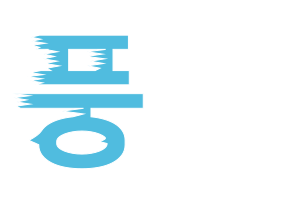

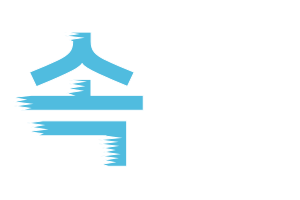

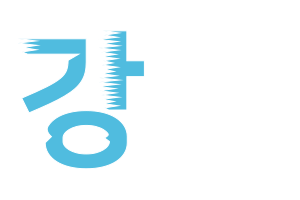

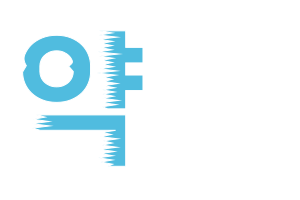

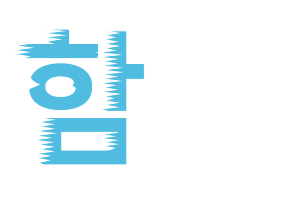

In [24]:
input_letters = ["바", "람", "풍", "속", "강", "약", "함"] # 바람
av = 50

for letter in input_letters:
    glyph_origin = glyphcommands(f, letter)    
    glyph_origin_direct = get_dir_list(glyph_origin)
    
    cutted_glyph = cut_glyph(["+right", "+left", "+up", "+down"], 6, glyph_origin, glyph_origin_direct)
    cutted_glyph_direct = get_dir_list(cutted_glyph)
    
    mod_glyph = make_design_glyph(cutted_glyph, cutted_glyph_direct, av)
    mod_path = Path(mod_glyph)
    
    page = document(300, 200, 'pt').addpage()
    pen = shape().stroke(rgb(265, 265, 265)).fill(rgb(80, 188, 223))
    page.place(pen.path(mod_path.scale(144/f.density).translate(20, 144)))
    show(page)